::: callout-note
This is an attempt to learn/understand/implement the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) by Alexey Dosovitskiy et al. using PyTorch. Resources used:

-   [Zero to Mastery Learn PyTorch for Deep Learning](https://www.learnpytorch.io/08_pytorch_paper_replicating/)
-   [lucidrains/vit-pytorch](https://github.com/lucidrains/vit-pytorch/tree/main)
-   [labml.ai](https://nn.labml.ai/transformers/vit/index.html)
:::

### An overview of ViTs

![ViT](vits.PNG)

The ViT architecture is composed of several stages: - **Split image into fixed-size patches**: The input image is split into a sequence of flattened 2D patches. The image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ (*read as The vector x is an element of the set of real numbers with a shape of H by W by C*) is reshaped into a sequence of flattened 2D patches $\mathbf{x_p} \in \mathbb{R}^{N \times (P^2 \cdot C)}$, where $N = \frac{HW}{P^2}$ is the number of patches, $P$ is the patch size, $H \times W$ is the resolution of the original image, and $C$ is the number of channels. $N$ also serves as the effective input sequence length for the Transformer.

-   **Linear embedding each patch**: The transformer uses *a constant latent vector size D* through all of its layers, so they **flatten the patches and map to D dimensions** using a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embedding**. The benefit of using an embedding rather than just the image values is that an embedding is a learnable representation of the image that can improve with training.

-   **Positional embedding**: The transformer does not have any built-in notion of position, so some information about the relative position of the patches is provided to the models using a learnable embedding at each patch to retain positional information. The resulting sequence of embedding vectors serves as input to a standard transformer encoder.

-   **Norm**: [Layer Normalization](https://arxiv.org/abs/1607.06450) is applied to stabilize training and improve generalization.

-   **Multi-head Attention**: The multi-head attention block is the core building block of the Transformer architecture. It consists of $H$ parallel attention layers, called attention heads. Each attention head is composed of three linear projections, which are used to compute the query, key, and value tensors required for the attention mechanism. The attention heads are concatenated and projected again to obtain the final output of the multi-head block. The multi-head attention block is followed by a residual connection and layer normalization.

-   **MLP**: The MLP is a feed-forward neural network with two linear projections and a GELU non-linearity in between them. and a drop out layer after each.

### Breaking down the equations in the paper.

### Equation 1 (Patch embeddings): Split the image into fixed-size patches, linearly embed them, add positional embeddings

$Equation 1$:

$\begin{aligned} \mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E} \in \mathbb{R}^{(N+1) \times D} \end{aligned}$

In transformers, an embedding refers to the process of representing discrete tokens as continuous dense vectors. Embeddings are a learnable parameter, meaning they are typically initialized randomly at the beginning of training and then updated throughout the learning process. In ViT-Base, this was $768$:

![patch_embeddings](hidden_dims.PNG)

$Equation 1$:

$\begin{aligned} \mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E} \in \mathbb{R}^{(N+1) \times D} \end{aligned}$

This equation describes the patch embeddings which is a combination of the class token, patch embeddings, and positional encoding. It captures both the global context of the image (through the class token) and the local information from the individual patches. Let's break it down:

1.  **Class Token** ($\mathbf{x}_{\text {class}}$): The class token is a special token that represents the image as a whole. It carries high-level information about the image.
2.  **Patch embeddings** ($\mathbf{x}_p^1 \mathbf{E}; \mathbf{x}_p^2 \mathbf{E}; \cdots ; \mathbf{x}_p^N \mathbf{E}$): The image is divided into $N$ patches and each patch $\mathbf{x}_p^i$ is multiplies by a learnable embedding matrix $\mathbf{E}$ to transform each patch into a lower dimensional representation.
3.  **Concatenation of components**: The previous components are concatenated together (denoted by the semicolon)
4.  **Positional encoding** ($\mathbf{E}_{pos}$): The positional encoding provides information about the spatial location of each patch.

For ViT-Base, best performing **patch size** was $16$. The resolution of the images used in this paper are $224$:

![model_variants](model_variants.PNG)

![training_resolution](training_resolution.PNG)

![patch_size](patch_size.PNG)

Let's do this by hand

In [1]:
resolution = 224 # All training is done on resolution 224
height = resolution
width = resolution
color_channels = 3
patch_size = 16

# Number of patches N = (H*W)/P^2
number_of_patches = int((height*width)/(patch_size**2))

# Print something useful
print(f"For a patch size of {patch_size}, an image of size {height}x{width} with {color_channels} color channels, results into {number_of_patches} patches")

For a patch size of 16, an image of size 224x224 with 3 color channels, results into 196 patches


Let's also illustrate the following statement from the paper:

> The input image is split into a sequence of flattened 2D patches. The image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ (*read as The vector x is an element of the set of real numbers with a shape of H by W by C*) is reshaped into a sequence of flattened 2D patches $\mathbf{x_p} \in \mathbb{R}^{N \times (P^2 \cdot C)}$, where $N = \frac{HW}{P^2}$ is the number of patches, $P$ is the patch size, $H \times W$ is the resolution of the original image, and $C$ is the number of channels. $N$ also serves as the effective input sequence length for the Transformer.

In [2]:
# image vector: H, W, C
input_image = (height, width, color_channels)

# Reshaped into a sequence of flattened 2D patches N x (P^2.C)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels) 

print(f"Input image shape: {input_image}")
print(f"Flattened image shape: {embedding_layer_output_shape}")

Input image shape: (224, 224, 3)
Flattened image shape: (196, 768)


## Turning image into a sequence of patches

Now that we have a basic idea of how an input image will be converted into a sequence of patches, let's try to implement it in code.

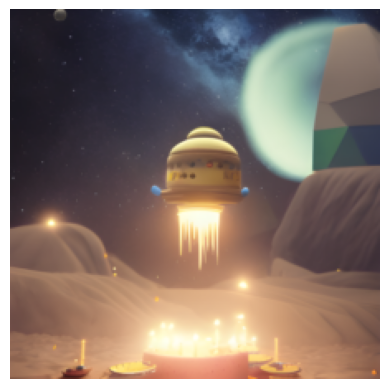

In [3]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load image
image = "blog_image.png"
image = Image.open(image)

# Resize image as 224x224 like in the paper
image = transforms.Resize((resolution, resolution))(image)

# Convert image to tensor
image = transforms.ToTensor()(image)

# Visualize image
plt.imshow(image.permute(1, 2, 0)) # permute to (H, W, C) from (C, H, W) as matplotlib expects
plt.axis(False);

Awesome. Now let's turn this image into patches like in the ViT paper. Let's start by visualizing the top row of patched pixels.

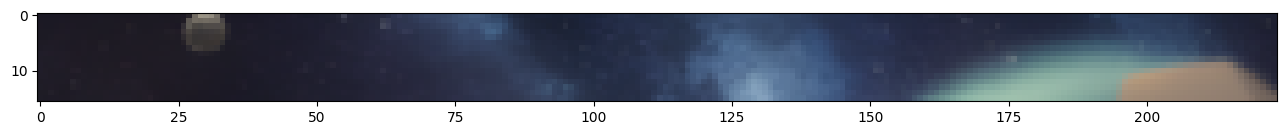

In [4]:
# Permute image shape from (C, H, W) to (H, W, C) as matplotlib expects
image_permuted = image.permute(1, 2, 0)

# Visualize top row of patched pixels
patch_size = 16
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Now let's turn it into patches. We can do this by iterating through the number of patches there'd be in the top row.

Number of patches per row : 14.0
Patch size: 16 pixels x 16 pixels


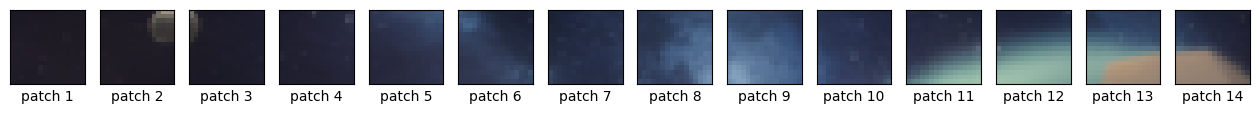

In [5]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, 'Image size must be divisible by patch size.'
print(f'Number of patches per row : {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots to show the patches
fig, axs = plt.subplots(nrows = 1,
                        ncols = int(num_patches),
                        figsize = (patch_size, patch_size),
                        sharex = True,
                        sharey = True)

# Display each patch
for i in range(int(num_patches)):
    axs[i].imshow(image_permuted[:patch_size, i*patch_size:(i+1)*patch_size, :])
    axs[i].set_xlabel(f"patch {i+1}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Now, doing this for the entire image:

Number of patches per row : 14.0
Patch size: 16 pixels x 16 pixels


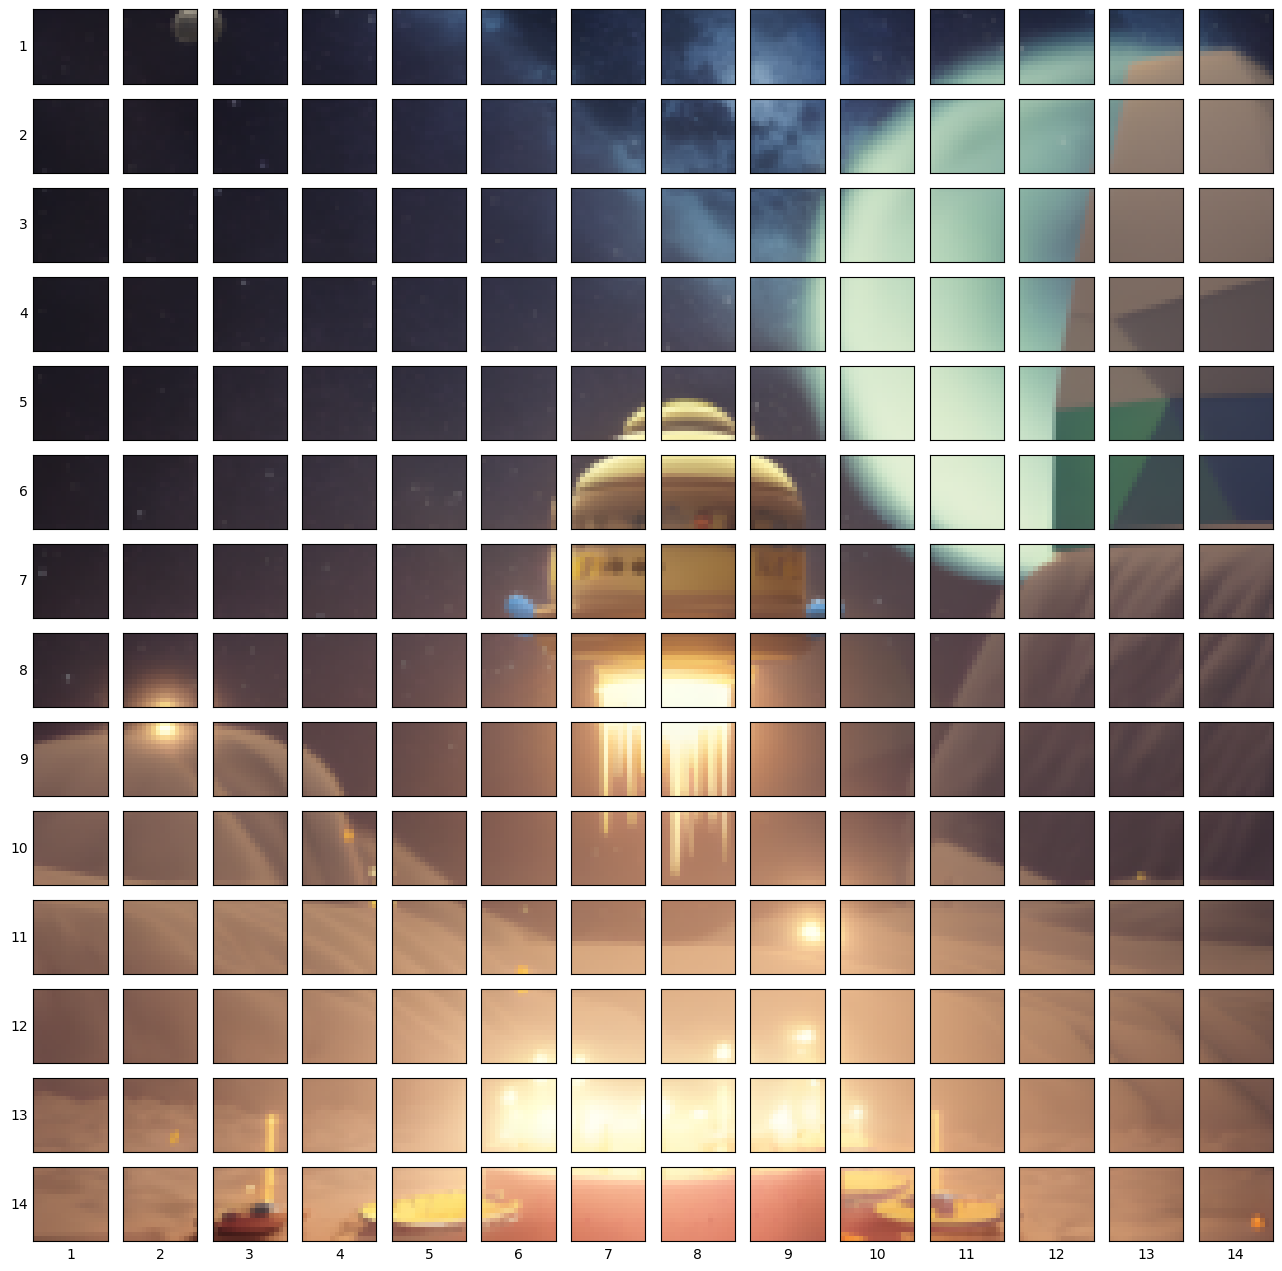

In [6]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, 'Image size must be divisible by patch size.'
print(f'Number of patches per row : {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots to show the patches
fig, axs = plt.subplots(
    nrows = int(num_patches),
    ncols = int(num_patches),
    figsize = (patch_size, patch_size),
    sharex = True,
    sharey = True
)

for i in range(int(num_patches)):
    for j in range(int(num_patches)):
        # Add patch to subplot
        axs[i, j].imshow(image_permuted[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xlabel(j + 1)
        axs[i, j].set_ylabel(i + 1,  rotation = "horizontal", ha = "right", va = "center")
        axs[i, j].label_outer()

Now let's turn these patches into an embedding and convert them into a sequence.

## Creating image patches with `torch.nn.Conv2d()`

So, how do we turn an image into patches like shown above and linearly embed them? The authors state that this can be achieved from **feature maps** of a CNN. **feature maps** refer to the activations produced when an image is passed through a convolution layer.

![image_patches](image_patches.png){width="1200," fig.align="center"}

Consider the feature maps produced by a convolution operation: $$
\frac{W - F + 2P}{S} + 1
$$ where $W$ is the input size, $F$ is the filter size, $P$ is the padding and $S$ is the stride.

As illustrated in the *patchifying* image in the previous section, for a patch size of $16$ an image of size $224 \times 224$ would produce $14 \times 14$ patches. This can be achieved by using a convolution layer with a kernel size of $16$ and a stride of $16$ i.e:

$$
\frac{224 - 16 + (2*0)}{16} + 1 = 14
$$ This means that the filter will be applied to the image at intervals of $16$ pixels i.e 14 times in the horizontal and vertical directions, which is exactly what we want.

For convolution layer, `input channels = 3 (RGB)`, `output channels = 768 (embedding size as shown in Table 1)`, `kernel size = 16`, `stride = 16`, `padding = 0`.

Just as a recap:

> The input image is split into a sequence of flattened 2D patches. The image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ (*read as The vector x is an element of the set of real numbers with a shape of H by W by C*) is reshaped into a sequence of flattened 2D patches $\mathbf{x_p} \in \mathbb{R}^{N \times (P^2 \cdot C)}$, where $N = \frac{HW}{P^2}$ is the number of patches, $P$ is the patch size, $H \times W$ is the resolution of the original image, and $C$ is the number of channels. $N$ also serves as the effective input sequence length for the Transformer.

In [7]:
# image vector: H, W, C
input_image = (height, width, color_channels)

# Reshaped into a sequence of flattened 2D patches N x (P^2.C)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels) 

print(f"Input image shape: {input_image}, -----> (H, W, C)")
print(f"Output(flattened 2d patches): {embedding_layer_output_shape}, -----> (N, P^2.C)")

Input image shape: (224, 224, 3), -----> (H, W, C)
Output(flattened 2d patches): (196, 768), -----> (N, P^2.C)


Okay, let's code this up

In [8]:
import torch.nn as nn

# Define the desired patch size
patch_size = 16

# Create conv2d layer that will turn image into patch embeddings
conv2d = nn.Conv2d(
    in_channels = 3, # Input image channels
    out_channels = 768, # Embedding channels
    kernel_size = patch_size, # Each patch will be 16x16 pixels
    stride = patch_size, # Patch non-overlapping stride
    padding = 0 # No padding
)

Our beloved image:

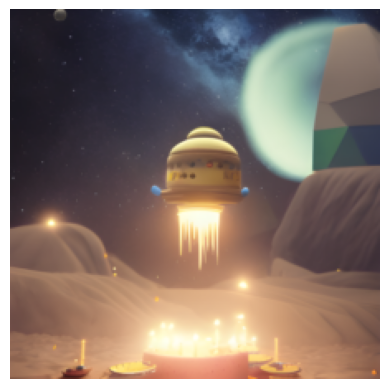

In [9]:
plt.imshow(image.permute(1, 2, 0))
plt.axis(False);

when passed through the convolution layer will be transformed as:

In [10]:
image_out_of_conv = conv2d(image.unsqueeze(0)) # Unsqueeze to add a batch dimension
print(f"Original image shape: {image.shape} -----> (N, C, H, W)")
print(f"Conv2d output shape: {image_out_of_conv.shape} -----> (batch_size, embedding_dim, H_out, W_out)")

Original image shape: torch.Size([3, 224, 224]) -----> (N, C, H, W)
Conv2d output shape: torch.Size([1, 768, 14, 14]) -----> (batch_size, embedding_dim, H_out, W_out)


We get 768 activations (which is the embedding size of Vit-Base) of size $14 \times 14$. We can visualize 5 random activations:

Showing random feature maps at indexes: [204, 458, 193, 45, 474]


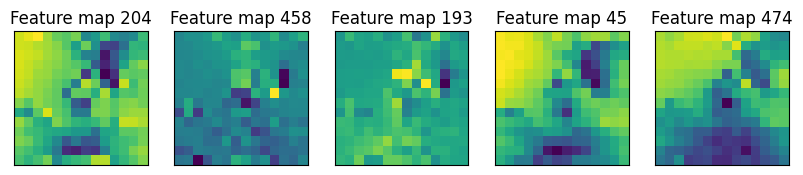

In [11]:
# Plot 5 random feature maps
import random
random_idx = random.sample(range(768), 5)
print(f"Showing random feature maps at indexes: {random_idx}")

fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (10, 10))

for i, idx in enumerate(random_idx):
    axs[i].set_title(f"Feature map {idx}")
    axs[i].imshow(image_out_of_conv[:, idx, :, :].detach().numpy().squeeze())
    axs[i].set_xticks([])
    axs[i].set_yticks([])

These feature maps are **learnable** which means they will be updated during training to best represent the input image.

## Flattening the patch embeddings

Our goal was to reshape 2D images of dimension $224 \times 224 \times 3 \ (H, W, C)$ into a sequence of flattened 2D patches of dimension $196 \times 768 \ (N, p^2C)$. The output of the convolution layer is of shape:

In [12]:
# Print the output shape of the conv layer
print(f"Conv2d output shape: {image_out_of_conv.shape} -----> (batch_size, embedding_dim, H_out, W_out)")

Conv2d output shape: torch.Size([1, 768, 14, 14]) -----> (batch_size, embedding_dim, H_out, W_out)


We've done the $768$ part i.e, $p^2C$. How do we do the $196$ part i.e Number of patches? As before the tells us how to do this:

> As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection E (Eq. 1) is applied to patches extracted from a CNN feature map. As a special case, the patches can have spatial size 1x1, which means that **the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension**. The classification input embedding and position embeddings are added as described above.

Let's flatten our feature maps and see what we get:

In [13]:
# Create a flatten layer
flatten = nn.Flatten(start_dim = 2, end_dim = 3)
flatten

Flatten(start_dim=2, end_dim=3)

Now, let's put the whole process together starting with the image:

In [14]:
print(f"Original image shape: {image.unsqueeze(0).shape} -----> (batch_size, channels, H, W)")
# Pass image through conv layer which turns it into a sequence of patches
image_out_of_conv = conv2d(image.unsqueeze(0)) # Unsqueeze to add a batch dimension
print(f"Conv2d output shape: {image_out_of_conv.shape} -----> (batch_size, embedding_dim, H_out, W_out)")
# Pass feature maps to flatten layer
image_out_of_flatten  = flatten(image_out_of_conv)
print(f"Flattened feature map shape: {image_out_of_flatten.shape} -----> (batch_size, embedding_dim, number_of_patches/sequence_length)")

Original image shape: torch.Size([1, 3, 224, 224]) -----> (batch_size, channels, H, W)
Conv2d output shape: torch.Size([1, 768, 14, 14]) -----> (batch_size, embedding_dim, H_out, W_out)
Flattened feature map shape: torch.Size([1, 768, 196]) -----> (batch_size, embedding_dim, number_of_patches/sequence_length)


So the desired outputs was: $N \times (p^2C)$ i.e $196 \times 768$.

Our current output is: $[1, 768, 196]$

Close enough. We can use `torch.permute()` to swap the dimensions:

In [15]:
# Permute flatten output to (batch_size, number_of_patches/sequence_length, embedding_dim)
image_out_of_flatten_permuted = image_out_of_flatten.permute((0, 2, 1))
print(f"Patch embedding shape: {image_out_of_flatten_permuted.shape} -----> (batch_size, number_of_patches/sequence_length, embedding_dim)")

Patch embedding shape: torch.Size([1, 196, 768]) -----> (batch_size, number_of_patches/sequence_length, embedding_dim)


Awesome!! We have successfully reshaped our image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ ($224 \times 224 \times 3$) into a sequence of flattened 2D patches $\mathbf{x_p} \in \mathbb{R}^{N \times (P^2 \cdot C)}$ ($196 \times 768$). where $N = \frac{HW}{P^2}$ is the number of patches, $P$ is the patch size, $H \times W$ is the resolution of the original image, and $C$ is the number of channels. $N$ also serves as the effective input sequence length for the Transformer.

## Turning the ViT patch embedding layer into a PyTorch module.

Now let's put everything we've done so far into a PyTorch module. We'll call it `PatchEmbeddings`:

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Create a class for the PatchEmbedding layer
class PatchEmbedding(nn.Module):
    """
    This class converts a 2D image into a 1D sequence of learnable input embeddings.
    """

    def __init__(self, in_channels, patch_size, embedding_dim):
        super().__init__()

        # Create a conv2d layer that will turn image into patch embeddings
        self.convert_image_to_patch_embeddings = nn.Conv2d(
            in_channels = in_channels,
            out_channels = embedding_dim,
            kernel_size = patch_size,
            stride = patch_size,
            padding = 0
        )

        # Create a flatten layer to convert embedding into a sequence
        self.flatten_patch_embeddings = nn.Flatten(start_dim = 2, end_dim = 3)

    # Forward method to convert image to patch embeddings
    def forward(self, x):
        # Asser image dimensions are correct shape
        resolution = x.shape[-1]
        assert resolution % patch_size == 0, f"Image resolution ({resolution}) must be divisible by patch size ({patch_size})"

        # Pass image through conv layer to get patch embeddings
        x_patched = self.convert_image_to_patch_embeddings(x)
        # Flatten patches into sequences
        x_flat = self.flatten_patch_embeddings(x_patched)
        # Permute sequence to (batch_size, sequence_length, embedding_dim)
        x_flat = x_flat.permute(0, 2, 1)
        return x_flat

Awesome, let's try this on a single image:

In [17]:
# Create a patch embedding layer
patch_embed = PatchEmbedding(
    in_channels = 3, # Input image channels
    patch_size = 16, # Each patch will be 16x16 pixels
    embedding_dim = 768 # Embedding dimension for each patch
)

# Pass image through patch embedding layer
print(f"Original 2D image shape: {image.unsqueeze(0).shape} -----> (batch_size, channels, H, W)")
image_embeddings = patch_embed(image.unsqueeze(0))
print(f"Patched embeddings shape: {image_embeddings.shape} -----> (batch_size, sequence_length, embedding_dim)")

Original 2D image shape: torch.Size([1, 3, 224, 224]) -----> (batch_size, channels, H, W)
Patched embeddings shape: torch.Size([1, 196, 768]) -----> (batch_size, sequence_length, embedding_dim)


Awesome!! We have successfully reshaped our image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ ($224 \times 224 \times 3$) into a sequence of flattened 2D patches $\mathbf{x_p} \in \mathbb{R}^{N \times (P^2 \cdot C)}$ ($196 \times 768$). where $N = \frac{HW}{P^2}$ is the number of patches, $P$ is the patch size, $H \times W$ is the resolution of the original image, and $C$ is the number of channels. $N$ also serves as the effective input sequence length for the Transformer.

## Create the class token embedding $\mathbf{x_{\text{class}}}$

$Equation 1$:

$\begin{aligned} \mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E} \in \mathbb{R}^{(N+1) \times D} \end{aligned}$

Looking at equation 1, we see that the class token $\mathbf{x_{\text{class}}}$ is the first element of the sequence. So what is the `class token`? The authors state:



![class](class.png){width="1200," fig.align="center"}



Simply put, the `class` token is a learnable parameter that is added to the beginning of the sequence of embedded patches, **just like any other patch**. It is a learnable embedding that is used to introduce information about the entire image to the model.

With that in mind, let's once again, review the shape of the embedded patches:

In [18]:
# Print the shape of image embeddings
print(f"Image embeddings shape: {image_embeddings.shape} -----> (batch_size, number_of_patches/sequence_length, embedding_dim)")

Image embeddings shape: torch.Size([1, 196, 768]) -----> (batch_size, number_of_patches/sequence_length, embedding_dim)


Therefore to "prepend" a learnable embedding to the sequence of embedded patches, we need to create a tensor of shape $[1, 1, 768] \ ----> \ (\text{batch size, number of patches, embedding dim)}$ and concatenate it to the start of the sequence of embedded patches. So, how many number of patches would we expect, yes $197$. Let's do this:

In [19]:
# Get the batch size, N and embedding dimension
batch_size, num_patches, embedding_dim = image_embeddings.shape

# Create a learnable class token parameter
class_token = nn.Parameter(torch.randn((batch_size, 1, embedding_dim)))
print(f"Class token shape: {class_token.shape} -----> (batch_size, 1, embedding_dim)")

Class token shape: torch.Size([1, 1, 768]) -----> (batch_size, 1, embedding_dim)


> In PyTorch, torch.nn.Parameter is a class that is used to indicate to the PyTorch framework that a given tensor should be considered a model parameter. Model parameters are tensors that are **learned and updated during the training process**. Exactly what we want!

Now let's concatenate the class token to the sequence of embedded patches using `torch.cat()`

In [20]:
# Prepend the learnable class token to the sequence of image embeddings
image_embedding_with_class_token = torch.cat((class_token, image_embeddings), dim = 1) # Tensors must have the same shape except for the dimension to concatenate on

# Print out the shape of the image embeddings with class token
print(f"Image embeddings with class token shape: {image_embedding_with_class_token.shape} -----> (batch_size, sequence_length + 1, embedding_dim)")

Image embeddings with class token shape: torch.Size([1, 197, 768]) -----> (batch_size, sequence_length + 1, embedding_dim)


## Creating the position embeddings $\mathbf{E}_{pos}$

Now that we have the class token embedding and the patch embeddings, we need to add the positional embeddings. The authors state:

![](pos_embs.png){width="1200," fig.align="center"}

Position embeddings are a way to provide the model with information about the spatial positions of the elements in the sequence. They are represented as **learnable** 1D tensors and added to the patch embeddings. So with this info, what's their dimension? Well, the current embeddings are of shape $[1, 197, 768]$. We need to add a position embedding to each of the $197$ patches. So the position embeddings should be of shape $[1, 197, 768]$. This can also be confirmed from equation 1:

$Equation 1$:

$\begin{aligned} \mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E_{pos}} \in \mathbb{R}^{(N+1) \times D} \end{aligned}$

where $\mathbf{E_{pos}}$ has the shape $(N+1) \times D$ i.e $197 \times 768$.

With this information, let's create a learnable parameter for the position embeddings:

In [21]:
# Get the batch size, N and embedding dimension
batch_size, num_patches, embedding_dim = image_embedding_with_class_token.shape

# Create a learnable positional embedding parameter
position_embedding = nn.Parameter(torch.randn((batch_size, num_patches, embedding_dim)))
print(f"Positional embedding shape: {position_embedding.shape} -----> (batch_size, sequence_length + 1, embedding_dim)")

Positional embedding shape: torch.Size([1, 197, 768]) -----> (batch_size, sequence_length + 1, embedding_dim)


Now, let's add the position embeddings to the sequence of embedded patches:

In [22]:
# Add the positional embedding to the image embeddings with class token
image_embeddings_with_pos_embedding = image_embedding_with_class_token + position_embedding
print(position_embedding)
print(f"\nImage embeddings with positional embedding shape: {image_embeddings_with_pos_embedding.shape} -----> (batch_size, sequence_length + 1, embedding_dim)")

Parameter containing:
tensor([[[ 1.6083, -0.5081,  0.3021,  ..., -1.1457, -1.4223,  0.0837],
         [-0.9941,  0.5328, -3.0513,  ...,  1.7700,  0.4271, -0.1395],
         [ 1.2788, -1.8625, -0.3671,  ...,  0.0031,  0.4365, -0.1117],
         ...,
         [-0.2169, -1.9232,  0.2619,  ...,  0.9441, -1.3348, -0.0928],
         [-2.5909, -0.8286,  0.6863,  ...,  0.6277,  1.1681,  1.5674],
         [-1.1946, -1.1495,  1.3369,  ..., -1.2889, -0.0095, -1.3112]]],
       requires_grad=True)

Image embeddings with positional embedding shape: torch.Size([1, 197, 768]) -----> (batch_size, sequence_length + 1, embedding_dim)


Awesome! We have successfully implemented the patch embeddings layer of the ViT architecture. Now on to the next adventure.

## Equation2: Multi-head self self attention (MSA)

The next step after the patch embeddings is the Transformer encoder. The transformer encoder consists of alternating layers of **multi-head self attention** and **MLP** blocks. These are represented in Equation 2 and 3 respectively:

```{=tex}
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\

\end{aligned}
```
Equation 2 can be implemented using the following Pytorch layers:

1.  `torch.nn.LayerNorm()`: Applies layer normalization to normalize activations of neurons within a layer of a neural network. Unlike batch normalization which normalizes activations across a batch of examples, layer normalization normalizes activations for each example individually. This means that it normalizes along the feature dimension, typically the last dimension (columns), and not the batch dimension (rows).

2.  `torch.nn.MultiheadAttention()`: Applies multihead attention over a sequence of embeddings. In multi-head attention, the self-attention mechanism is applied multiple times in parallel. Each of these parallel attention heads has its own set of learnable parameters, including query, key, and value weight matrices. The key idea is that different heads can focus on capturing different patterns, relationships, or features in the input sequence.

3.  `residual connection`: The residual connection is a skip connection that adds the input to the output of the layer. This helps to stabilize the training process and improve the flow of information through the network.

Let's implement this:

In [23]:
# Create a Multi-Head Self Attention (MSA) block
class MSABlock(nn.Module):
    """
    This class performs Multi-Head Self Attention (MSA) block.
    """

    # Initialize the class with hyperparameters from the paper in Table 1
    def __init__(
            self,
            embed_dim,
            num_heads,
            dropout,
    ):
        super().__init__()

        # Create a normalization layer
        self.layer_norm = nn.LayerNorm(normalized_shape = embed_dim)

        # Create a multi-head self-attention block
        self.multihead_self_attention = nn.MultiheadAttention(
            embed_dim = embed_dim,
            num_heads = num_heads,
            dropout = dropout,
            batch_first = True
        )

    # Forward method to perform multi-head self attention on the input embeddings
    def forward(self, x): 
        shortcut = x # Create a shortcut of the input
        # Layer normalize the input
        x = self.layer_norm(x)
        # Pass input through multi-head self attention
        attn_output, _ = self.multihead_self_attention(
            query = x,
            key = x,
            value = x,
            need_weights = False
        )
        # Add the shortcut to the multi-head self attention output
        x = shortcut + attn_output
        return x

Not bad! Let's try it out by instantiating the class and passing in the patch embeddings:

In [24]:
# Instantiate the MSA block
msa_block = MSABlock(embed_dim = 768, num_heads = 12, dropout = 0.0)

# Pass image embeddings with positional embeddings through MSA block
patch_embeddings_through_msa = msa_block(image_embeddings_with_pos_embedding)
print(f"Patch embeddings: {image_embeddings_with_pos_embedding.shape} -----> (batch_size, sequence_length + 1, embedding_dim)")
print(f"Patch embeddings through MSA block shape: {patch_embeddings_through_msa.shape} -----> (batch_size, sequence_length + 1, embedding_dim)")

Patch embeddings: torch.Size([1, 197, 768]) -----> (batch_size, sequence_length + 1, embedding_dim)
Patch embeddings through MSA block shape: torch.Size([1, 197, 768]) -----> (batch_size, sequence_length + 1, embedding_dim)


## Equation 3: MLP

```{=tex}
\begin{aligned}
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\

\end{aligned}
```
Now let's implement the MLP block. The MLP block is composed of two linear layers with a GELU activation in between them. The MLP block is used to It introduces non-linearity, captures local patterns, and allows the model to learn complex relationships between elements at different positions in the sequence

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Create a MLP block 
class MLPBlock(nn.Module):
    """
    This class passes the input of the multihead attention block through a Multi-Layer Perceptron (MLP).
    """
    def __init__(self, embed_dim, mlp_size, dropout:float = 0.1):
        super().__init__()

        # Create layer normalization
        self.layer_norm = nn.LayerNorm(normalized_shape = embed_dim)

        # Create mlp layers
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embed_dim, out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(p = dropout),
            nn.Linear(in_features = mlp_size, out_features = embed_dim),
            nn.Dropout(p = dropout)
        )

    # Forward method to pass input through MLP block
    def forward(self, x):
        shortcut = x
        # Layer normalize the input
        x = self.layer_norm(x)
        # Pass input through MLP
        x = self.mlp(x)
        # Add shortcut to MLP output
        x = shortcut + x
        return x

In [26]:
#Let's try it out by passing the output of the MSA block to the MLP block:

mlp_block  = MLPBlock(embed_dim = 768, mlp_size = 3072, dropout = 0.1)
patch_embedding_through_msa_mlp_block = mlp_block(patch_embeddings_through_msa)
print(f"Shape of output of MSA block: {patch_embeddings_through_msa.shape}")
print(f"Shape of output of MLP block: {patch_embedding_through_msa_mlp_block.shape}")

Shape of output of MSA block: torch.Size([1, 197, 768])
Shape of output of MLP block: torch.Size([1, 197, 768])


## Combining the MSA and MLP blocks to create the Transformer Encoder

The transformer encoder is composed of alternating layers of multihead self attention and MLP blocks represented in Equation 2 and 3 respectively. This can also be seen in Figure 1 of the paper:

![](vits.PNG){width="1200," fig.align="center"}

The MSA helps the model capture relationships and dependencies between different patches in the image, while the MLP block helps the model learn these patterns. Let's implement the transformer encoder layer as below:

In [27]:
# Create MSA block
class MSABlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super().__init__()

        # Create layer normalization
        self.layer_norm = nn.LayerNorm(normalized_shape = embed_dim)

        # Create MSA block
        self.multihead_self_attention = nn.MultiheadAttention(
            embed_dim = embed_dim,
            num_heads = num_heads,
            dropout = dropout,
            batch_first = True
        )

    # Forward method to pass input through MSA block
    def forward(self, x):
        # Create shortcut of input
        shortcut = x
        # Layer normalize input
        x = self.layer_norm(x)
        # Pass input through MSA block
        attn_output, _ = self.multihead_self_attention(
            query = x,
            key = x,
            value = x,
            need_weights = False
        )
        # Residual connection
        x = shortcut + attn_output
        return x
    
# Create MLP block
class MLPBlock(nn.Module):
    def __init__(self, embed_dim, mlp_size, dropout:float = 0.1):
        super().__init__()

        # Create layer normalization
        self.layer_norm = nn.LayerNorm(normalized_shape = embed_dim)

        # Create mlp layers
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embed_dim, out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(p = dropout),
            nn.Linear(in_features = mlp_size, out_features = embed_dim),
            nn.Dropout(p = dropout)
        )

    # Forward method to pass input through MLP block
    def forward(self, x):
        # Create shortcut of input
        shortcut = x
        # Layer normalize input
        x = self.layer_norm(x)
        # Pass input through MLP block
        x = self.mlp(x)
        # Residual connection
        x = shortcut + x
        return x



class TransformerEncoderBlock(nn.Module):
    """
    This class stacks the MSA and MLP blocks together.
    """
    def __init__(self,
                 embed_dim: int = 768,
                 num_heads: int = 12,
                 mlp_size: int = 3072,
                 mlp_dropout: float = 0.1,
                 attn_dropout: float = 0.0,
                 ):
        super().__init__()

        # Create MSA block (equation 2)
        self.msa_block = MSABlock(
            embed_dim = embed_dim,
            num_heads = num_heads,
            dropout = attn_dropout
        )

        # Create MLP block (equation 3)
        self.mlp_block = MLPBlock(
            embed_dim = embed_dim,
            mlp_size = mlp_size,
            dropout = mlp_dropout
        )
    
    # Forward method to pass input through the encoder block
    def forward(self, x):
        # Pass input through MSA block
        x = self.msa_block(x)

        # Pass input through MLP block
        x = self.mlp_block(x)

        return x

In [28]:
# Try out the TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()
transformer_encoder_block_output = transformer_encoder_block(image_embeddings_with_pos_embedding)
print(f"Transformer encoder block output shape: {transformer_encoder_block_output.shape} -----> (batch_size, sequence_length + 1, embedding_dim)")

Transformer encoder block output shape: torch.Size([1, 197, 768]) -----> (batch_size, sequence_length + 1, embedding_dim)


In [29]:
transformer_encoder_block(image_embeddings_with_pos_embedding)

tensor([[[ 0.9929, -0.8838,  1.7580,  ..., -0.5866, -0.9210, -1.0825],
         [-1.3200,  0.2910, -2.7106,  ...,  1.9743, -0.0353, -0.2454],
         [ 1.0773, -1.8989, -0.3714,  ..., -0.2718,  0.4366, -0.2234],
         ...,
         [ 0.1351, -2.0571,  0.0245,  ...,  1.2104, -1.0754, -0.2300],
         [-2.0877, -0.9197,  0.1068,  ...,  0.8308,  1.0474,  0.8283],
         [-0.9481, -1.1129,  0.7810,  ..., -1.7301, -0.3514, -1.4589]]],
       grad_fn=<AddBackward0>)

In a typical transformer architecture, transformer encoders are stacked sequentially on top of each other.

In the encoder part of the Transformer, multiple identical layers of transformer encoders are stacked on top of each other. Each encoder layer consists of two main sub-layers: a multi-head self-attention mechanism and a position-wise feedforward neural network. These layers are stacked to capture hierarchical features and representations of the input data.

The idea of stacking multiple encoder layers is to allow the model to learn increasingly abstract and complex representations of the input data by passing it through multiple levels of self-attention and feedforward transformations. This stacking of encoder layers is a key architectural choice that contributes to the Transformer's ability to handle a wide range of tasks in natural language processing and other domains.

It is also noteworthy that PyTorch has in-built transformer encoder layers as part of torch.nn.TransformerEncoderLayer

In [30]:
torch_transformer_encoder_block = nn.TransformerEncoderLayer(
    d_model = 768,
    nhead = 12,
    dim_feedforward = 3072,
    dropout=0.1,
    activation = "gelu",
    batch_first = True,
    norm_first = True
)

torch_transformer_encoder_block

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [31]:
# Get a summary using torchsummary
from torchinfo import summary 
summary(model = torch_transformer_encoder_block, 
        input_size = (1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Creating a ViT model

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Create a class for the PatchEmbedding layer
class PatchEmbedding(nn.Module):
    """
    This class converts a 2D image into a 1D sequence of learnable input embeddings.
    """

    def __init__(self, in_channels, patch_size, embedding_dim):
        super().__init__()

        # Create a conv2d layer that will turn image into patch embeddings
        self.convert_image_to_patch_embeddings = nn.Conv2d(
            in_channels = in_channels,
            out_channels = embedding_dim,
            kernel_size = patch_size,
            stride = patch_size,
            padding = 0
        )

        # Create a flatten layer to convert embedding into a sequence
        self.flatten_patch_embeddings = nn.Flatten(start_dim = 2, end_dim = 3)

    # Forward method to convert image to patch embeddings
    def forward(self, x):
        # Asser image dimensions are correct shape
        resolution = x.shape[-1]
        assert resolution % patch_size == 0, f"Image resolution ({resolution}) must be divisible by patch size ({patch_size})"

        # Pass image through conv layer to get patch embeddings
        x_patched = self.convert_image_to_patch_embeddings(x)
        # Flatten patches into sequences
        x_flat = self.flatten_patch_embeddings(x_patched)
        # Permute sequence to (batch_size, sequence_length, embedding_dim)
        x_flat = x_flat.permute(0, 2, 1)
        return x_flat



class ViT(nn.Module):
    """
    A PyTorch implementation of a Vision Transformer (ViT) base
    """
    def __init__(self,
                 img_size: int = 224,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768,
                 embedding_dropout: float = 0.1,
                 num_classes: int = 10, # Number of classes in the dataset
                 num_heads: int = 12,
                 num_transformer_layers: int = 12,
                 mlp_size: int = 3072,
                 mlp_dropout: float = 0.1,
                 attn_dropout: float = 0.0,


                 ):



        super().__init__() # Initialize parent class

        # Assert that the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size ({img_size}) must be divisible by patch size ({patch_size})"

        # Number of patches = (H * W) / p**2
        self.num_patches = int((img_size * img_size) / (patch_size**2))

        # Create a learnable embedding to the sequence of embedded patches
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim))

        # Create a learnable embedding for the position of each patch
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim))

        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p = embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(
            in_channels = in_channels,
            patch_size = patch_size,
            embedding_dim = embedding_dim
        )

        # Create classifier head y = LN(Z^0)
        self.classifier_head = nn.Sequential(
            nn.LayerNorm(normalized_shape = embedding_dim),
            nn.Linear(in_features = embedding_dim, out_features = num_classes)

        )

        # Create Transformer encoder blocks: They are stacked on top of each other sequentially
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(
                embed_dim = embedding_dim,
                num_heads = num_heads,
                mlp_size = mlp_size,
                mlp_dropout = mlp_dropout,
                attn_dropout = attn_dropout
            ) for l in range(num_transformer_layers)]
        )

    # Forward method to pass input through the ViT  
    def forward(self, x):

        # Get batch size
        batch_size = x.shape[0]

        # Create class token embedding that matches batch size
        class_token = self.class_embedding.expand(batch_size, -1, -1) # (batch_size, 1, embedding_dim)

        # Create patch embedding
        x = self.patch_embedding(x)

        # Prepend the class token to the sequence of patch embeddings
        x = torch.cat((class_token, x), dim = 1)

        # Add position embedding to patch embedding
        x = x + self.position_embedding

        # Apply dropout after adding positional embedding (Appendidix B.1)
        x = self.embedding_dropout(x)

        # Pass embedded sequence through transformer encoder blocks
        x = self.transformer_encoder(x)

        # Get just the class token from the sequence and apply classifier head
        x = self.classifier_head(x[:, 0])

        return x

In [33]:
# Test what the ViT model outputs
dummy_image = torch.randn((1, 3, 224, 224)) # (batch_size, channels, height, width)

# Instantiate ViT model
vit = ViT(num_classes=3)

# Pass dummy image through ViT model
vit(dummy_image)

tensor([[-1.2148, -0.2238,  0.1651]], grad_fn=<AddmmBackward0>)

In [34]:
from torchinfo import summary

# Get a summary of the ViT model
summary(model=vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         col_names=["input_size", "output_size", "num_params", "trainable"],
        # col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                Input Shape               Output Shape              Param #                   Trainable
ViT (ViT)                                                              [32, 3, 224, 224]         [32, 3]                   152,064                   True
├─PatchEmbedding (patch_embedding)                                     [32, 3, 224, 224]         [32, 196, 768]            --                        True
│    └─Conv2d (convert_image_to_patch_embeddings)                      [32, 3, 224, 224]         [32, 768, 14, 14]         590,592                   True
│    └─Flatten (flatten_patch_embeddings)                              [32, 768, 14, 14]         [32, 768, 196]            --                        --
├─Dropout (embedding_dropout)                                          [32, 197, 768]            [32, 197, 768]            --                        --
├─Sequential (transformer_encoder)                                     [32,